# Cable Driven Parallel Robot 2T Model Tests
#### Created by: Alexander Herdt

This notebook is designed to train RL-agents for control of a cable driven parallel robot (CDPR) after cable break.  The CDPR is described as an RL-environment and has two translational degrees of freedom (2T) and a point mass endeffector/platform in a YZ-coordinate system. The specifications are derived by simplification of the CABLAR robot developed by the Chair of Mechatronics of the University of Duisburg-Essen. 

The following implementation is primarily based on the stable-baselines3 package which uses OpenAI gym as a basis for creating RL environments and Pytorch for training models with GPU integration. Furthermore Tensorboard can be used as a tool for observing leaning processes. Please refer to https://stable-baselines3.readthedocs.io/en/master/index.html for additional information.

## Imports

In [1]:
%matplotlib widget
import json
import datetime
import pickle
import timeit
import os
import numpy as np
import pandas as pd
from cdpr.utils import *
from environment import states
from environment.environment import EmergencyStrategyCDPR
from environment.observations import *
from environment.actions import Action, cable_forces_action, cable_force_gradients_action, platform_wrench_action
from environment.rewards import *
from environment.tasks import stop_body2D_task
from evaluation import evaluation
from evaluation.visualize import *
from simulation.cablar import cablar1r2t, cablar2t
from simulation.agents import RLAgent
from typing import Dict, List, Union
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3 import SAC, PPO
from sb3_contrib import TQC
from stable_baselines3.common.env_checker import check_env

c:\ProgramData\Anaconda3\envs\RL1\lib\site-packages\gym\envs\registration.py:216: UserWarning: WARN: Overriding environment ALE/Tetris-v5
  logger.warn("Overriding environment {}".format(id))
c:\ProgramData\Anaconda3\envs\RL1\lib\site-packages\gym\envs\registration.py:216: UserWarning: WARN: Overriding environment ALE/Tetris-ram-v5
  logger.warn("Overriding environment {}".format(id))
c:\ProgramData\Anaconda3\envs\RL1\lib\site-packages\gym\envs\registration.py:216: UserWarning: WARN: Overriding environment ALE/Adventure-v5
  logger.warn("Overriding environment {}".format(id))
c:\ProgramData\Anaconda3\envs\RL1\lib\site-packages\gym\envs\registration.py:216: UserWarning: WARN: Overriding environment ALE/Adventure-ram-v5
  logger.warn("Overriding environment {}".format(id))
c:\ProgramData\Anaconda3\envs\RL1\lib\site-packages\gym\envs\registration.py:216: UserWarning: WARN: Overriding environment ALE/AirRaid-v5
  logger.warn("Overriding environment {}".format(id))
c:\ProgramData\Anaconda3\

### CDPR Setup
Specify a cable driven parallel robot that is an instance of the CDPR class and an array coordinates.  
The coordinate array is necessary for workspace calculation and initialization of environment.

In [2]:
cdpr = cablar1r2t # CDPR Modell
env_kwargs = {"goal":np.array([[2.72],[2.0]])}
cables_idx = [0,2,3] # which cables should be used i.e. a cable that is not specified is considered "broken"
Ts = 0.005 # timestep 
max_episode_timesteps = 10000
# Coordinate grid for workspace calculation and initialization of environment
Y = np.linspace(-5,5,100) 
Z = np.linspace(0,5,100)
# PHI = np.deg2rad(np.arange(-30,30,1))
PHI = np.array([0])
coordinates = create_grid_coordinates([Y,Z,PHI])
Y_test = np.arange(-4.5,5.5,0.5)
Z_test = np.arange(0.5,5.5,0.5)
test_coord = create_grid_coordinates([Y_test,Z_test,np.array([0])])
test_coord,_ = calc_static_workspace(cablar1r2t, test_coord, cables_idx=[0,1,2,3])

### Observations
Define all observation sets and their limits with the `Observation` class.  
All observations will be normalized by default to the interval __[-1,1]__ if you do not specify otherwise.  
Please use the `ObservationFunction` class and specify which variables will be observed if you would like to define a new observation function.  
Any observable variables should be defined as `StateVariable` or `DerivedVariable` object.

In [3]:
# Observe [pose, spatial_velocities, cable_forces] 
obs0 = Observation(obsfunc0,
                   low=[-5,0,-np.pi/2,-100,-100,-10,150,150,150],
                   high=[5,5,np.pi/2,100,100,10,2500,2500,2500])
# Observe [pose, velocities, cable_forces, position_error] 
obs1 = Observation(obsfunc1,
                   low=[-5,0,-np.pi/2,-100,-100,-10,-150,150,150,0,0],
                   high=[5,5,np.pi/2,100,100,10,2500,2500,2500,10,5])

### Actions
Define actions as action functions and action spaces that will be used by the Agent.  
If new actions need to be defined please use the `Action` class.

In [4]:
act0 = cable_forces_action
act1 = cable_force_gradients_action
act2 = platform_wrench_action

### Rewards
Define rewards and the parameter values that should be tested.  
The parameter values should be in a dict of the form `{"parameter_name_0":value, "parameter_name_1":value, ...}`.  
If new rewards need to be defined please use the `Reward` class.

In [6]:
def negative_spatial_velocity(cdpr,c1,c2,c3,c4):
    """reward = -c1*cdpr.v**c2-c3*cdpr.omega**c4"""
    reward = -c1*cdpr.v**c2-c3*cdpr.omega**c4
    return reward

def reward0(cdpr, c1, c2):
    """Reward for (1-c1*cdpr.v)+(1-c2*cdpr.omega)"""
    reward = (1-c1*cdpr.v)+(1-c2*cdpr.omega)
    return reward

rew0 = Reward(reward0)
rew_params0 = {"c1":[0.01],"c2":[3]}

rew1 = Reward(positive_exp_distance)
rew_params1 = {"c1":[1]}


### Tasks
Define a task as a set of functions that determine whether termination criteria are met during an eposide.
If new tasks need to be defined please use the `Task` class.

In [7]:
task0 = stop_body2D_task

### Definition of tests
Specify each test as a dictiionary `{"obs":your_observation, "act": your_action, "rew": your_reward, "rew_params": paramters_to_test, "task":your_task}`.  

In [8]:
tests = {
        0:{"obs":obs0,
           "act":act1,
           "rew":rew0,
           "rew_params":rew_params0,
           "task":task0},
        }

### Test Observation and Reward before running full test procedures

In [9]:
for test_num in tests:
    print(f"Checking test configuration {test_num}", end="\t")
    test = tests[test_num]
    obs = test["obs"]
    act = test["act"]
    rew = test["rew"]
    rew_params = test["rew_params"]
    task = test["task"]
    if rew_params:
        param_combos = list(itertools.product(*list(rew_params.values())))
    else:
        param_combos = [1]
    for i, params in enumerate(param_combos):
        params = dict(zip(rew_params.keys(), params))
        if i==0:
            env = EmergencyStrategyCDPR(
                cdpr=cdpr,
                cables_idx=cables_idx,
                Ts=Ts,
                max_episode_timesteps = max_episode_timesteps,
                coordinates=coordinates,
                observation=obs,
                action=act,
                reward=rew,
                task=task,
                rew_params=params,
                **env_kwargs
                )
        else:
            env.set_act(act)
            env.set_obs(obs)
            env.set_rew(rew)
            env.set_task(task)  
            check_env(env)          
    print("passed")

Checking test configuration 0	passed


## Testing
The testing procedure creates a folder in `models_path` that is named after the current datetime and is referred to as `model_path`. This folder contains a `setup_info.json` file and separate folders for every test.

Additional info:
- `setup_info.json` describes the configuration of the CDPR simulation and the foldernames for the different tests (a number `t_j` consisting of a testnumber `t` and parameter combination `j`).  
- Each test will be repeated once for every seed specified in `seeds` to account for the effect of random initialisation
- test folders will contain a trained model that was optained after  `total_timesteps` and a model that achieved the result during evaluations
- Evaluations are run after every `eval_freq` timesteps for `n_eval_episodes`
- Training logs will be stored in `model_path`+`logs`
- Training logs can accessed with **Tensorboard** by opening a python command prompt in the `model_path` folder and entering `tensorboard --logdir logs`

### Specify tests and configurations
The tests use default Hyperparameters if not specified otherwise.  
TQC: https://sb3-contrib.readthedocs.io/en/master/modules/tqc.html

In [10]:
algo = TQC
total_timesteps = 1e6 # number of training timesteps
eval_freq = 100000 # number of timesteps before each evaluation
n_eval_episodes = 30 # number of episodes to run during evalutation
use_gSDE = False
n_envs = 1
config = {}

In [11]:
seeds = [1,42,777]
testing_coordinates = coordinates
tests_now = list(tests.keys())
# tests_path = os.path.join(os.getcwd(),"tests")
current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
models_folder = f"{cdpr.cdpr_type}_{current_time}"
# tests_now = [0,1,2]
tests_path = r"C:\Users\Alex\UNI\Master\Abschlussarbeit Master\best1r2t"
models_folder = r""
model_path = os.path.join(tests_path, models_folder)
model_path = r"C:\Users\Alex\UNI\Master\Abschlussarbeit Master\best1r2t"
os.makedirs(model_path, exist_ok = True)

### Run testing procedures

In [11]:
log_path = os.path.join(model_path,"logs")
setup_info = os.path.join(model_path, 'setup_info.txt')
setup_info = {"name":models_folder,
              "cables": cables_idx,
              "DoF":f"{cdpr.cdpr_type}",
              "Ts":Ts,
              "total_timesteps":total_timesteps}

test_infos = {}

model_num = 1
for t in tests_now:
    test = tests[test_num]
    obs = test["obs"]
    act = test["act"]
    rew = test["rew"]
    task = test["task"]
    test_infos[t] = {"obs_desc":obs.description,
                     "act_desc":act.description,
                    "rew_desc": rew.description,
                    "num":{}}
    rew_params = list(test["rew_params"].values())
    for i in range(len(rew_params)):
        param = rew_params[i]
        for j in range(len(param)):
            param_value = param[j]
            if type(param_value) == np.ndarray:
                rew_params[i][j] = param_value.tolist()
    if rew_params:
        param_combos = list(itertools.product(*list(test["rew_params"].values())))
    else:
        param_combos = [1]
    j = 0    
    for params in param_combos:
        test_infos[t]["num"][f"{t}_{j}"] = dict(zip(test["rew_params"].keys(),params))
        test_infos[t]["num"][f"{t}_{j}"]["tb_log_num"] = {}
        for seed in seeds:
            test_infos[t]["num"][f"{t}_{j}"]["tb_log_num"][seed] = model_num
            model_num +=1
        j += 1
    
setup_info["test_infos"] = test_infos
with open(os.path.join(model_path, "setup_info.json"),"w") as json_file:
    json.dump(setup_info, json_file, indent=4, separators = (",",":"))

## Test Loop

In [12]:
all_results = {}
mpl.use("Agg")
for t in tests_now:
    test = tests[t]
    obs= test["obs"]
    act = test["act"]
    rew = test["rew"]
    if rew_params:
        param_combos = list(itertools.product(*list(test["rew_params"].values())))
    else:
        param_combos = [1]
        
    for j, params in enumerate(param_combos):
        rew_params = dict(zip(test["rew_params"].keys(),params))
        env = EmergencyStrategyCDPR(
            cdpr=cdpr,
            cables_idx=cables_idx,
            Ts=Ts,
            max_episode_timesteps=max_episode_timesteps,
            coordinates=coordinates,
            observation=obs,
            action=act,
            reward=rew,
            task=task,
            rew_params=rew_params,
            **env_kwargs
            )
        
        for seed in seeds:
            # Vectorize environment for faster execution and add a Monitor wrapper for evaluation 
            vec_env = make_vec_env(lambda: env,
                                    seed = seed,
                                    monitor_kwargs=dict(info_keywords=("is_success",)),
                                    n_envs=n_envs)
            # Save path for best evaluated models during training
            savedir = os.path.join(model_path, f"{t}_{j}",str(seed))
            savedir = r"C:\Users\Alex\UNI\Master\Abschlussarbeit Master\PythonRL\tests\1R2T_20230219_130411\0_0\42"
            best_model_save_path = os.path.join(savedir, f"best")
            model_save = os.path.join(savedir,"Cdpr.zip")
            eval_env = make_vec_env(lambda: env)
            eval_callback = EvalCallback(eval_env, n_eval_episodes=n_eval_episodes,
                                        best_model_save_path=best_model_save_path,
                                        log_path=best_model_save_path, eval_freq=eval_freq,
                                        deterministic=True, render=False)
            vec_env.seed(seed)
            model = TQC.load(path=model_save[:-4],env=vec_env)
            # model = algo('MlpPolicy', 
            #                 vec_env, 
            #                 device='cuda',
            #                 verbose=0, 
            #                 seed = seed,
            #                 tensorboard_log=log_path,
            #                 **config)
            
            # Train the agent
            # start = datetime.datetime.now()
            # print(f"Begin training Model {t}_{j} seed {seed}. Start: {start.strftime('%d.%m.%Y %H:%M:%S')}")
            # begin = timeit.default_timer()
            # model.learn(total_timesteps=int(total_timesteps), callback=eval_callback)
            # finish = timeit.default_timer()
            # end = datetime.datetime.now()
            # duration = finish-begin
            # print(f"Done training Model {t}_{j} seed {seed}. End: {end.strftime('%d.%m.%Y %H:%M:%S')}")
            # print(f"Duration: {end-start}")
            # model.save(model_save)
            
            print("Creating trajectories")
            test_data = evaluation.test_coordinates(env, model, test_coord)
            with open(os.path.join(savedir,'test_data.pkl'), 'wb') as file:
                pickle.dump(test_data, file)
            print("Saved trajectories")        
            successes = np.array(test_data["successes"])
            failures = np.array(test_data["failures"])
            timeouts = np.array(test_data["timeouts"])
            # fig = visualize_tests_2D(env, successes, failures, timeouts)
            # plt.savefig(os.path.join(savedir,"CDPR2T_.png"), format="png",dpi=150)
            # plt.close()
            all_results[savedir] = {"root":os.path.dirname(os.path.dirname(savedir)), 
                                    "t_j": f"{t}_{j}", 
                                    "seed": seed,
                                    "obs": obs.description,
                                    "act": act.description,
                                    "rew": rew.description
                                    }
            test_table = {
                'Y':[], 
                'Z':[],
                'PHI':[],
                'success':[],
                'timeout':[],
                'failure':[],
                'duration':[],
                'brake_time':[],
                'rms_jerk':[],
                'rms_angular_jerk':[],
                'max_velocity':[],
                'max_angular_velocity':[],
                'rms_velocity':[],
                'rms_angular_velocity':[],
                'trajectory_length':[],
                'total_rotation':[],
                'trajectory_distance':[],
                'relative_length':[],
                'rms_forces':[],
                'max_force':[],
                'max_force_delta':[],
                'continuity_cost':[], 
                'df_continuity_cost':[]}
            print("Evaluating trajectories")
            for k, trajectory in enumerate(test_data["trajectories"]):
                try:
                    poses, velocities, accelerations, forces, success, duration, done = trajectory.values()
                except:
                    poses, velocities, accelerations, forces, success, duration, done, metrics = trajectory.values()
                positions = poses[:,:2]
                translation_velocities = velocities[:,:2]
                translation_accelerations = accelerations[:,:2]
                orientations = poses[:,[-1]]
                angular_velocites = velocities[:,[-1]]
                angular_accelerations = accelerations[:,[-1]]
                    
                translation_metrics = evaluation.evaluate_translation_trajectory(positions, translation_velocities, translation_accelerations)
                rotation_metrics = evaluation.evaluate_rotation_trajectory(orientations,angular_velocites,angular_accelerations)
                force_metrics = evaluation.evaluate_force_trajectory(forces)
                cc_mean = evaluation.continuity_cost(forces, env.f_min, env.f_max)
                delta_f = np.diff(forces, axis=0)
                brake_time = evaluation.find_not_rising_index(np.linalg.norm(translation_velocities,axis=1))*env.Ts
                if len(delta_f)>1:
                    df_cc_mean = evaluation.continuity_cost(delta_f, -100, 100)
                else:
                    df_cc_mean = 0
                metrics = {}
                metrics.update(translation_metrics)
                metrics.update(rotation_metrics)
                metrics.update(force_metrics)
                metrics.update({"continuity_cost":cc_mean, 
                                "df_continuity_cost":df_cc_mean,})
                trajectory.update({"metrics":metrics})
                # Viz
                y = np.round(poses[0,0])
                z = np.round(poses[0,1])
                phi = np.round(np.rad2deg(poses[0,2]))
                test_table["Y"].append(y)
                test_table["Z"].append(z)
                test_table["PHI"].append(z)
                test_table["success"].append(success)
                test_table["timeout"].append(not done)
                test_table["failure"].append(not success and done)
                test_table["duration"].append(duration)
                test_table["brake_time"].append(brake_time)
                for metric, value in metrics.items():
                    if len(metric)==2:
                        test_table[metric[0]].append(value[0])
                        test_table[metric[1]].append(value[1])
                    else:
                        test_table[metric].append(value)
                if k%2 == 0:
                    fig1 = visualize_forces(env, poses[0], Ts, forces)
                    fig2 = visualize_velocities(env, poses[0], Ts, velocities)
                    fig3 = visualize_poses(env, Ts, poses)
                    figs = [fig1, fig2, fig3]
                    fig_combi = combine_figures(figs)
                    plt.savefig(os.path.join(savedir,(f"forces_velocities_positions_{y}_{z}.png")), format="png",dpi=150)
                    plt.close('all')
            #         break
            #     break
            # break
            # Dump

            test_table = pd.DataFrame(test_table)
            result = {
                "success_rate": sum(test_table["success"])/len(test_table["success"]),
                "failure_rate": sum(test_table["failure"])/len(test_table["failure"]),
                "timeout_rate": sum(test_table["timeout"])/len(test_table["timeout"]),
                "mean_jerk": np.mean(test_table["rms_jerk"]),
                "mean_velocity": np.mean(test_table["rms_velocity"]),
                "max_velocity": np.max(test_table["max_velocity"]),
                "mean_duration": np.mean(test_table["duration"]),
                "mean_success_duration": np.mean(test_table["duration"][test_table["success"]]),
                "mean_brake_time":np.mean(test_table["brake_time"]),
                "mean_relative_length": np.mean(test_table["relative_length"]),
                "mean_forces": np.mean(test_table["rms_forces"]),
                "mean_max_forces": np.mean(test_table["max_force"]),
                "mean_max_force_delta": np.mean(test_table["max_force_delta"]),
                "mean_continuity_cost": np.mean(test_table["continuity_cost"]),
                "mean_df_continuity_cost": np.mean(test_table["df_continuity_cost"]),
                "average_distance_to_centroid": evaluation.average_distance_to_centroid(successes)}
            all_results[savedir].update(result)
            with pd.ExcelWriter(os.path.join(savedir, "CDPR2T_new.xlsx")) as writer:
                df = pd.DataFrame(test_table)
                df.to_excel(writer, sheet_name= "test",engine="xlsxwriter")
        print("Saved test data")

NameError: name 'test_params' is not defined

In [ ]:
def evaluate_rotation_trajectory(orientations, angular_velocities, angular_accelerations):
    jerk = np.diff(angular_accelerations, axis=0)
    rms_jerk = np.sqrt(np.mean(np.square(jerk)))
    max_velocity = np.max(angular_velocities)
    rms_velocity = np.sqrt(np.mean(np.square(angular_velocities)))
    total_rotation = np.sum(np.sqrt(np.sum(np.diff(orientations, axis=0)**2, axis=1)))
    metrics = {
        "rms_angular_jerk": rms_jerk,
        "max_angular_velocity": max_velocity,
        "rms_angular_velocity": rms_velocity,
        "total_rotation":total_rotation
    }
    return metrics

In [ ]:
obs = env.reset()
for i in range(10000):
    action, _ = model.predict(obs)
    res = env.step(action)
    if env.v<=0.01 and env.phi_doty<=0.01:
        print("Success")
        break
    elif env.done:
        print("Done",i)
        print(env.is_failure(),env.is_success(),env.is_timeout())
        break
    

Done 68
True False False


In [ ]:
import numpy as np
import matplotlib as mpl
import math
from matplotlib import pyplot as plt
from typing import List, Union

_linestyles = [
    ('solid', 'solid'),      # Same as (0, ()) or '-'
    ('dotted', 'dotted'),    # Same as (0, (1, 1)) or ':'
    ('dashed', 'dashed'),    # Same as '--'
    ('dashdot', 'dashdot'),  # Same as '-.'
    ('dotted',                (0, (1, 1))),
    ('long dash with offset', (5, (10, 3))),
    ('densely dotted',        (0, (1, 1))),
    ('loosely dashed',        (0, (5, 10))),
    ('dashed',                (0, (5, 5))),
    ('densely dashed',        (0, (5, 1))),
    ('loosely dashdotted',    (0, (3, 10, 1, 10))),
    ('dashdotted',            (0, (3, 5, 1, 5))),
    ('densely dashdotted',    (0, (3, 1, 1, 1))),
    ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
    ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))]

def _get_digits(x:float):
    digits = len(str(int(x)).replace("-",""))-1
    return digits

def visualize_forces(cdpr, pose, Ts, forces):
    fig, ax = plt.subplots(constrained_layout=True, figsize = (6,2))
    m = cdpr.m
    cables_idx = cdpr.cables_idx
    digits = _get_digits(cdpr.f_max)
    y_max = math.ceil(cdpr.f_max/10**digits)*10**digits
    if cables_idx is None:
        cables_idx = list(range(m))
    for i in range(m):
        ax.plot(forces[:,i],ls=_linestyles[i][1], label=f"$f_{cables_idx[i]+1}$")
    ax.set_title(f"Seilkräfte", fontsize = 14) #für Startpos. = {np.round(pose,1)}
    xticks = ax.get_xticks()
    ax.set_xticks(xticks)
    xlabels = [np.round(i*Ts, len(str(Ts))) for i in xticks]
    ax.set_xticklabels(xlabels, fontsize = 12)
    ax.set_yticks(np.arange(0, y_max, 10**digits/2, dtype="int"))
    ax.set_yticklabels(ax.get_yticks(), fontsize = 12)
    ax.grid(1)
    ax.set_xmargin(0)
    ax.set_xlim(-0.01*len(forces)) 
    ax.set_ylim(-10**(digits-1), y_max) 
    ax.set_xlabel(f"t [s]", fontsize = 12)
    ax.set_ylabel("f [N]", fontsize = 12)
    ax.legend(bbox_to_anchor=(1.2,0.5), fontsize = 12, loc="center right")
    return fig

def visualize_velocities(cdpr, pose, Ts, velocities, angular_velocities=None):
    fig, ax = plt.subplots(constrained_layout=True, figsize = (6,2))
    trans_axes = cdpr.trans_axes
    for i in range(cdpr.trans_dof):
        ax.plot(velocities[:,i],ls=_linestyles[i][1], label=f"$\dot {trans_axes[i]}$")
        
    if angular_velocities is not None:
        ax1 = ax.twinx()
        rot_symbols = cdpr.pose_variables[-cdpr.rot_dof:]
        for j in range(cdpr.rot_dof):
            ax1.plot(angular_velocities[:,j],ls=_linestyles[j+i][1], label=f"$\dot {rot_symbols[j]}$")
        ax1.set_yticks(ax1.get_yticks())
        ax1.set_yticklabels(np.round(ax1.get_yticks(),3), fontsize = 12)
        ax1.set_ylabel("$\dot \phi$ [rad/s]$", fontsize = 12) 
    ax.set_title(f"Geschwindigkeiten des Endeffektors", fontsize = 14) #= {np.round(pose,1)}
    ax.set_xticks(ax.get_xticks())
    xticks = ax.get_xticks()
    ax.set_xticks(xticks)
    xlabels = [np.round(i*Ts, len(str(Ts))) for i in xticks]
    ax.set_xticklabels(xlabels, fontsize = 12)
    ax.set_yticks(ax.get_yticks())
    ax.set_yticklabels(np.round(ax.get_yticks(),3), fontsize = 12)
    ax.grid(1)
    ax.set_xmargin(0)
    ax.set_xlim(-0.01*len(velocities)) 
    ax.set_xlabel(f"t [s]", fontsize = 12)
    ax.set_ylabel("v [m/s]", fontsize = 12)
    ax.legend(bbox_to_anchor=(1.2,0.5), fontsize = 12, loc="center right")
    return fig
    
def visualize_poses(cdpr, Ts, poses):
    fig, ax = plt.subplots(constrained_layout=True, figsize = (6,2))
    positions = poses[:,:cdpr.trans_dof]
    trans_axes = cdpr.trans_axes
    title = "Bewegung des Endeffektors"
    for i in range(cdpr.trans_dof):
        ax.plot(positions[:,i],ls=_linestyles[i][1], label=f"${trans_axes[i]}$")
        
    if cdpr.rot_dof>0:
        ax1 = ax.twinx()
        orientations = poses[:,-cdpr.rot_dof:]
        rot_symbols = cdpr.pose_variables[-cdpr.rot_dof:]
        for j in range(cdpr.rot_dof):
            ax1.plot(orientations[:,j],ls=_linestyles[j+i][1], label=f"${rot_symbols[j]}$")
        ax1.set_yticks(ax1.get_yticks())
        ax1.set_yticklabels(np.round(ax1.get_yticks(),3), fontsize = 12)
        ax1.set_ylabel("$\phi$ [rad]$", fontsize = 12) 
        
    ax.set_title(title, fontsize = 14)
    ax.set_xticks(ax.get_xticks())
    xticks = ax.get_xticks()
    ax.set_xticks(xticks)
    xlabels = [np.round(i*Ts, len(str(Ts))) for i in xticks]
    ax.set_xticklabels(xlabels, fontsize = 12)
    ax.set_yticks(ax.get_yticks())
    ax.set_yticklabels(np.round(ax.get_yticks(),3), fontsize = 12)
    ax.grid(1)
    ax.set_xmargin(0)
    ax.set_xlim(-0.01*len(poses)) 
    ax.set_xlabel(f"t [s]", fontsize = 12)
    ax.set_ylabel("$r_p[m]$", fontsize = 12)
    ax.legend(bbox_to_anchor=(1.2,0.5), fontsize = 12, loc="center right")
    return fig

def visualize_tests_2D(cdpr, successes, failures, timeouts):
    fig = plt.figure(figsize=(8,4))
    ax = fig.add_subplot(111)
    axes_names = cdpr.axes_names
    x_min,x_max,y_min,y_max = cdpr.axes.ravel()
    b = cdpr.b
    b_left = b[:,b[0,:]==x_min]
    b_right = b[:,b[0,:]==x_max] 
    
    if failures.shape[0] !=0 and timeouts.shape[0] !=0:
        A = failures
        B = timeouts
        nrows, ncols = A.shape
        dtype={'names':['f{}'.format(i) for i in range(ncols)],
            'formats':ncols * [A.dtype]}
        C,idx1,idx2 = np.intersect1d(A.view(dtype), B.view(dtype),return_indices=True)
        failures = np.delete(A,idx1,0)
        
    title = "Bergung bei verschiedenen Startpositionen"
    bl = ax.scatter(b_left[0,:],b_left[1,:], s=60, c = "k", marker=9)
    br = ax.scatter(b_right[0,:],b_right[1,:], s=60, c = "k", marker=8)
    if successes.size != 0:
        sc = ax.scatter(successes[:,0],successes[:,1], s=60, c = "g", marker="o", label="Erfolg")
    if failures.size != 0:
        fail = ax.scatter(failures[:,0],failures[:,1], s=70, c = "r", marker="x", label="Kollision")
    if timeouts.size != 0:
        to = ax.scatter(timeouts[:,0],timeouts[:,1], s=40, c = "y", marker="D",label="nicht gestoppt")
    ax.legend( fontsize = 14, loc="upper center", ncol= 3)
    ax.set_xticks(np.arange(x_min, x_max+1, 1.0))
    ax.set_yticks(np.arange(y_min, y_max+1, 1.0))
    ax.set_xmargin(0)
    ax.set_xlabel(axes_names[0].capitalize()+" [m]", fontsize = 14)
    ax.set_ylabel(axes_names[1].capitalize()+" [m]", fontsize = 14)
    ax.set_xticklabels(ax.get_xticks(), fontsize = 12)
    ax.set_yticklabels(ax.get_yticks(), fontsize = 12)
    fig.subplots_adjust(bottom=0.15)
    return fig

def combine_figures(figs):
    num_figs = len(figs)
    fig, axs = plt.subplots(num_figs, 1, sharex= True, figsize=(6, 2*num_figs))
    if num_figs == 1:
        axs = [axs]
    for i, fig_i in enumerate(figs):
        for j, ax_i in enumerate(fig_i.axes):
            for line in ax_i.lines:
                new_line, = axs[i].plot(line.get_xdata(), line.get_ydata(), label=line.get_label())
                new_line.set_linestyle(line.get_linestyle())
                new_line.set_linewidth(line.get_linewidth())
                new_line.set_color(line.get_color())
                new_line.set_marker(line.get_marker())
                new_line.set_markersize(line.get_markersize())
            axs[i].set_xscale(ax_i.get_xscale())
            axs[i].set_yscale(ax_i.get_yscale())
            axs[i].set_xticks(ax_i.get_xticks()[1:])
            axs[i].set_xticklabels(ax_i.get_xticklabels()[1:])
            axs[i].set_ylabel(ax_i.get_ylabel(), fontsize=10)
            axs[i].set_title(ax_i.get_title(), fontsize=12)
            axs[i].set_xmargin(0)
            axs[i].grid(1)
            axs[i].legend(bbox_to_anchor=(1.25,0.5), fontsize = 12, loc="center right")
            axs[i].set_xlim(ax_i.get_xlim())
            axs[i].set_ylim(ax_i.get_ylim())
    axs[i].set_xlabel(ax_i.get_xlabel(), fontsize=10)
    fig.tight_layout()
    return fig

def visualize_movement(cdpr, Ts, positions):
    fig = plt.figure(figsize=(8,4))
    ax = fig.add_subplot(111)
    axes_names = cdpr.axes_names
    x_min,x_max,y_min,y_max = cdpr.axes.ravel()
    b = cdpr.b
    b_left = b[:,b[0,:]==x_min]
    b_right = b[:,b[0,:]==x_max] 
    ax.scatter(b_left[0,:],b_left[1,:], s=60, c = "k", marker=9)
    ax.scatter(b_right[0,:],b_right[1,:], s=60, c = "k", marker=8)
    start, =ax.plot(positions[0,0], positions[1,0],"ro", ms=5, label="start")
    end, = ax.plot(positions[0,-1], positions[1,-1],"gx", label="end", ms=15,mew=2)
    ax.plot(positions)
    ax.set_title(f"Bewegung des Endeffektors", fontsize = 14)
    ax.grid(1)
    ax.legend(bbox_to_anchor=(0.5,1.15), fontsize = 14, loc="upper center", ncol= 3)
    ax.set_xticks(np.arange(x_min, x_max+1, 1.0))
    ax.set_yticks(np.arange(y_min, y_max+1, 1.0))
    ax.set_xlabel(axes_names[0], fontsize = 14)
    ax.set_ylabel(axes_names[1], fontsize = 14)
    ax.set_xticklabels(ax.get_xticks(), fontsize = 12)
    ax.set_yticklabels(ax.get_yticks(), fontsize = 12)
    return fig

In [ ]:
def test_trajectory(cdpr,model,pose, max_timesteps):
    obs = cdpr.reset(pose.reshape(cdpr.n,1))
    for t in range(max_timesteps):
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, info = cdpr.step(action)
        if done:
            break
    
    success = info["is_success"]
    end = cdpr.pose
    duration = t*cdpr.Ts
    return success, end, done, duration
    
def generate_trajectory(cdpr,model,pose, max_timesteps):
    n = cdpr.n
    m = cdpr.m
    Ts = cdpr.Ts
    obs = cdpr.reset(pose.reshape(cdpr.n,1))
    poses = np.zeros((max_timesteps,n))
    velocities = np.zeros((max_timesteps,n))
    accelerations = np.zeros((max_timesteps,n))
    forces = np.zeros((max_timesteps,m))
    poses[0,:] = cdpr.pose.ravel()
    velocities[0,:] = cdpr.pose_dot.ravel()
    accelerations[0,:] = cdpr.pose_dot_dot.ravel()
    forces[0,:] = cdpr.f.ravel()
    for t in range(1,max_timesteps):
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, info = cdpr.step(action)
        poses[t,:] = cdpr.pose.ravel()
        velocities[t,:] = cdpr.pose_dot.ravel()
        accelerations[t,:] = cdpr.pose_dot_dot.ravel()
        forces[t,:] = cdpr.f.ravel()
        if done:
            break
    trajectory = {"poses": poses[:t+1,:],
                  "velocities": velocities[:t+1,:],
                  "accelerations": accelerations[:t+1,:],
                  "forces": forces[:t+1,:],
                  "success": info["is_success"],
                  "duration":t*Ts,
                  "done": done}
    return trajectory
def test_coordinates(cdpr, model, coordinates, save_freq=1, max_timesteps=10000):
    trajectories = []
    successes = []
    failures = []
    durations = []
    timeouts = []
    start_end= []
    for k, pose in enumerate(coordinates):
        start = pose
        if k%save_freq==0:
            trajectory = generate_trajectory(cdpr,model,pose, max_timesteps)
            trajectories.append(trajectory)
            success = trajectory["success"]
            done = trajectory["done"]
            end = trajectory["poses"][-1]
            duration = trajectory["duration"] 
        else:
            success, end, done, duration = test_trajectory(cdpr,model,pose, max_timesteps)
        if success:
            successes.append(pose)
        elif not done:
            timeouts.append(pose)
        else:
            failures.append(pose)
            
        start_end.append({"start":start,"end":end})
        durations.append(duration)
    test_data = {"trajectories":trajectories, 
                "successes":successes, 
                "failures":failures, 
                "durations":durations, 
                "timeouts":timeouts, 
                "start_end":start_end}
    return test_data

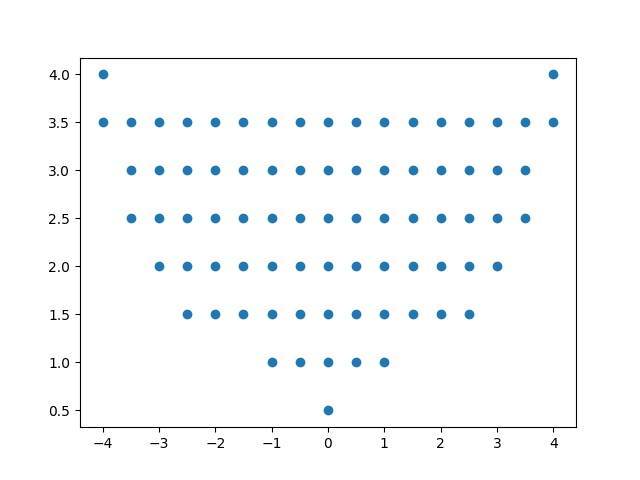

In [ ]:
fig, ax = plt.subplots()
ax.scatter(test_coord[:,0], test_coord[:,1])

In [ ]:
pose = test_coord[0].reshape(env.n,1)
max_timesteps = 10000
obs = env.reset(pose)
for t in range(max_timesteps):
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    if done:
        break

success = info["is_success"]
end = env.pose
duration = t*env.Ts